In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import cm
import time

In [21]:
def bsexact(sigma, r, E, T, s):
    d1 = (np.log(s/E) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    F = s * norm.cdf(d1) - np.exp(-r*T)*E*norm.cdf(d2)
    return F

In [22]:
def cev_explicit(S_max, N, M, K, T, r, sigma, gamma):
    dt = T / M
    dS = S_max / N
    S_grid = np.linspace(0, S_max, N+1)
    tau_grid = np.linspace(0, T, M+1)
    
    V = np.zeros((N+1, M+1))
    V[:, 0] = np.maximum(S_grid - K, 0)
    V[0, :] = 0
    V[N, :] = S_max - K * np.exp(-r * (T - tau_grid))
    
    for k in range(0, M):
        for j in range(1, N):
            S_j = S_grid[j]
            alpha = 0.5 * (sigma**2) * (S_j**(2*gamma)) * dt / (dS**2)
            beta = (r * S_j) * dt / (2 * dS)
            l_j = alpha - beta
            d_j = 1 - r * dt - 2 * alpha
            u_j = alpha + beta
            V[j, k+1] = l_j * V[j-1, k] + d_j * V[j, k] + u_j * V[j+1, k]
    
    return S_grid, V[:, -1]


In [23]:
def cev_implicit(S_max, N, M, K, T, r, sigma, gamma):
    dt = T / M
    dS = S_max / N
    S_grid = np.linspace(0, S_max, N+1)
    
    V = np.zeros((N+1, M+1))
    V[:, 0] = np.maximum(S_grid - K, 0)
    
    for k in range(M):
        V_prev = V[:, k].copy()
        
        A = np.zeros((N-1, N-1))
        b = np.zeros(N-1)
        
        V_lower = 0
        V_upper = S_max - K * np.exp(-r * (T - (k+1)*dt))
        
        for j in range(1, N):
            S_j = S_grid[j]
            
            alpha = 0.5 * sigma**2 * S_j**(2*gamma) * dt / dS**2
            beta = r * S_j * dt / (2 * dS)
            
            l_j = -(alpha - beta)
            d_j = 1 + r*dt + 2*alpha
            u_j = -(alpha + beta)
            
            if j == 1:
                A[0, 0] = d_j
                A[0, 1] = u_j
                b[0] = V_prev[j] - l_j * V_lower
            elif j == N-1:
                A[N-2, N-3] = l_j
                A[N-2, N-2] = d_j
                b[N-2] = V_prev[j] - u_j * V_upper
            else:
                A[j-1, j-2] = l_j
                A[j-1, j-1] = d_j
                A[j-1, j] = u_j
                b[j-1] = V_prev[j]
        
        try:
            V_internal = np.solve(A, b)
            V[1:N, k+1] = V_internal
        except:
            V_internal = np.linalg.lstsq(A, b, rcond=None)[0]
            V[1:N, k+1] = V_internal
        
        V[0, k+1] = V_lower
        V[N, k+1] = V_upper
    
    return S_grid, V

In [24]:
def cev_crank_nicolson(S_max, N, M, K, T, r, sigma, gamma):
    dt = T / M
    dS = S_max / N
    S_grid = np.linspace(0, S_max, N+1)
    
    V = np.zeros((N+1, M+1))
    V[:, 0] = np.maximum(S_grid - K, 0)
    
    for k in range(M):
        V_prev = V[:, k].copy()
        
        A_impl = np.zeros((N-1, N-1))
        A_expl = np.zeros((N-1, N-1))
        b = np.zeros(N-1)
        
        V_lower_prev = 0
        V_lower_next = 0
        V_upper_prev = S_max - K * np.exp(-r * (T - k*dt))
        V_upper_next = S_max - K * np.exp(-r * (T - (k+1)*dt))
        
        for j in range(1, N):
            S_j = S_grid[j]
            
            alpha = 0.5 * sigma**2 * S_j**(2*gamma) * dt / dS**2
            beta = r * S_j * dt / (2 * dS)
            
            l_expl = (alpha - beta) / 2
            d_expl = 1 - r*dt/2 - alpha
            u_expl = (alpha + beta) / 2
            
            l_impl = -(alpha - beta) / 2
            d_impl = 1 + r*dt/2 + alpha
            u_impl = -(alpha + beta) / 2
            
            if j == 1:
                A_impl[0, 0] = d_impl + 1
                A_impl[0, 1] = u_impl
                A_expl[0, 0] = d_expl + 1
                A_expl[0, 1] = u_expl
                b[0] = l_expl * V_lower_prev - l_impl * V_lower_next
            elif j == N-1:
                A_impl[N-2, N-3] = l_impl
                A_impl[N-2, N-2] = d_impl + 1
                A_expl[N-2, N-3] = l_expl
                A_expl[N-2, N-2] = d_expl + 1
                b[N-2] = u_expl * V_upper_prev - u_impl * V_upper_next
            else:
                A_impl[j-1, j-2] = l_impl
                A_impl[j-1, j-1] = d_impl + 1
                A_impl[j-1, j] = u_impl
                A_expl[j-1, j-2] = l_expl
                A_expl[j-1, j-1] = d_expl + 1
                A_expl[j-1, j] = u_expl
                b[j-1] = 0
        
        rhs = A_expl @ V_prev[1:N] + b
        
        try:
            V_next_internal = np.solve(A_impl, rhs)
            V[1:N, k+1] = V_next_internal
        except:
            V_next_internal = np.linalg.lstsq(A_impl, rhs, rcond=None)[0]
            V[1:N, k+1] = V_next_internal
        
        V[0, k+1] = V_lower_next
        V[N, k+1] = V_upper_next
    
    return S_grid, V

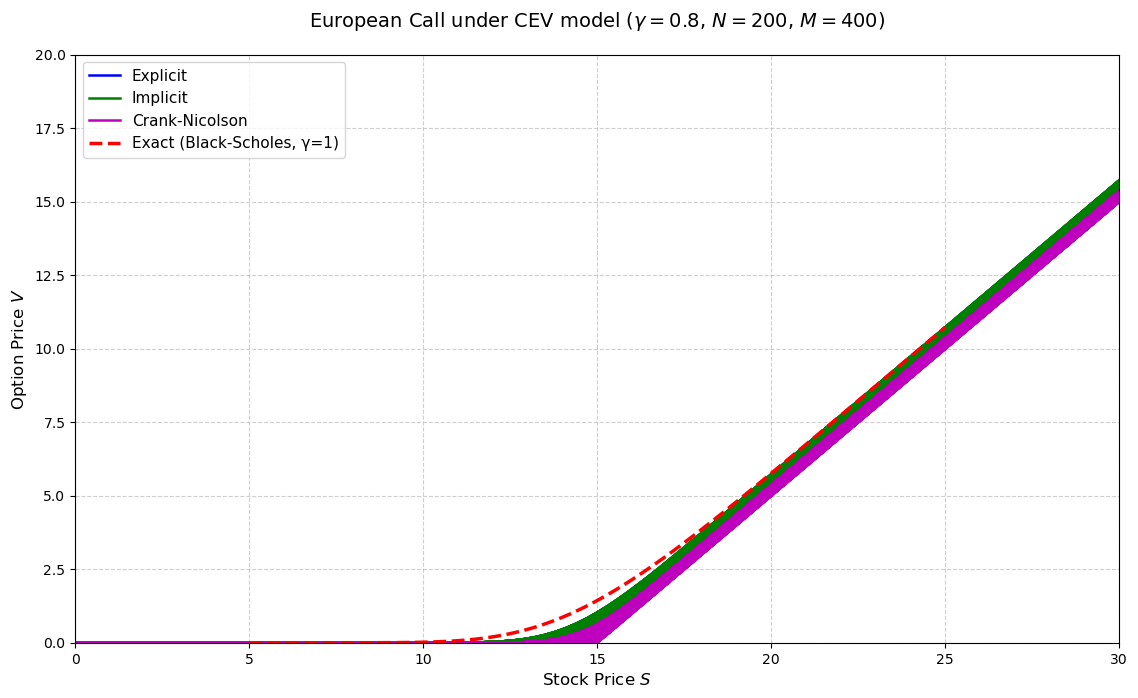

In [25]:
# Parameters (K = 15)
K = 15
r = 0.1
sigma = 0.25
T = 0.5
gamma = 0.8
S_max = 4 * K
N, M = 200, 400

# Solve using different methods
S_grid_explicit, V_explicit = cev_explicit(S_max, N, M, K, T, r, sigma, gamma)
S_grid_implicit, V_implicit = cev_implicit(S_max, N, M, K, T, r, sigma, gamma)
S_grid_cn, V_cn = cev_crank_nicolson(S_max, N, M, K, T, r, sigma, gamma)

# Exact Black-Scholes solution for comparison (gamma = 1)
S_ref = np.linspace(5, 25, 100)
V_exact = bsexact(sigma, r, K, T, S_ref)

# IMPORTANT: Clear all existing figures and legends to avoid duplicates
plt.close('all')
plt.ioff()  # Turn off interactive mode

# Create new figure with single plotting command
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all lines at once to ensure single legend entries
lines = []
lines.append(ax.plot(S_grid_explicit, V_explicit, 'b-', linewidth=1.8)[0])
lines.append(ax.plot(S_grid_implicit, V_implicit, 'g-', linewidth=1.8)[0])
lines.append(ax.plot(S_grid_cn, V_cn, 'm-', linewidth=1.8)[0])
lines.append(ax.plot(S_ref, V_exact, 'r--', linewidth=2.5)[0])

# Set labels for legend
labels = ['Explicit', 'Implicit', 'Crank-Nicolson', 'Exact (Black-Scholes, γ=1)']

# Create legend only once
ax.legend(lines, labels, fontsize=11, loc='upper left', frameon=True)

# Format the plot
ax.set_xlabel('Stock Price $S$', fontsize=12)
ax.set_ylabel('Option Price $V$', fontsize=12)
ax.set_title(r'European Call under CEV model ($\gamma=0.8$, $N=200$, $M=400$)', fontsize=14, pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(0, 30)
ax.set_ylim(0, 20)

# Adjust layout manually to avoid warnings
plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.08)

# Display the plot
plt.show()

# Turn interactive mode back on if needed
plt.ion()

In [26]:
#stability fig

50×100		0.0060s		0.0566s
100×200		0.0241s		0.2411s
200×400		0.0979s		1.5042s
400×800		0.3961s		27.9773s


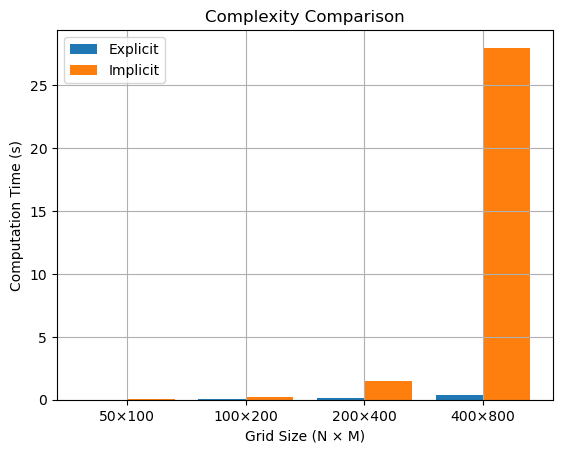

In [27]:
grid_sizes = [(50, 100), (100, 200), (200, 400), (400, 800)]
explicit_times = []
implicit_times = []

for N, M in grid_sizes:
    start_time = time.time()
    cev_explicit(S_max, N, M, K, T, r, sigma, 0.8)
    explicit_time = time.time() - start_time
    explicit_times.append(explicit_time)
    
    start_time = time.time()
    cev_implicit(S_max, N, M, K, T, r, sigma, 0.8)
    implicit_time = time.time() - start_time
    implicit_times.append(implicit_time)
    
    print(f"{N}×{M}\t\t{explicit_time:.4f}s\t\t{implicit_time:.4f}s")

grid_sizes_str = [f'{N}×{M}' for N, M in grid_sizes]
x_pos = np.arange(len(grid_sizes))
plt.bar(x_pos - 0.2, explicit_times, 0.4, label='Explicit')
plt.bar(x_pos + 0.2, implicit_times, 0.4, label='Implicit')
plt.xlabel('Grid Size (N × M)')
plt.ylabel('Computation Time (s)')
plt.title('Complexity Comparison')
plt.xticks(x_pos, grid_sizes_str)
plt.legend()
plt.grid(True)


In [28]:
#gammal fig